Une fois que les données d'entrainement ont subit la pipeline et entrainé les modeles, l'ensemble de test va subir cette pipeline avec les modèles entrainés par l'ensemble d'entraînement. l'ensemble de test subit la pipeline dans ce script.

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
path = r"C:\Users\ahmed\MFE project"    
df_tsv = pd.read_csv(os.path.join(path, [i for i in os.listdir(path) if i.find("DataBase_Norm_tsv")>-1][0])).fillna(0)
df_test = pd.read_csv(os.path.join(path, [i for i in os.listdir(path) if i.find("addfeat_Test_Amplicon")>-1][0])).fillna(0)

In [14]:
from joblib import dump, load
# to load the model
RF_local_loaded = load('RF_model_train_saved.joblib')
DT_local_loaded = load('DT_model_train_saved.joblib')
DT_local_loaded2 = load('DT_model_train_saved2.joblib')
scaler_loaded = load('normalizeMinMax_tsv_saved.joblib')

RF_global_loaded = load('RF_model_Global_train_saved.joblib')
RF_global_featselect = load("RF_featselect.joblib")

RF_global_RFE = load("RF_featselect_RFE.joblib")
RF_global_spearman = load("RF_featselect_Spearman.joblib")

step 1: avoir la colonne disant si une séquence est OPT avec un RF (local)

In [15]:
New_var1 = ['gc_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent']

pred = DT_local_loaded2.predict(df_test[New_var1])

In [5]:
from sklearn.metrics import confusion_matrix
# avec le Decision Tree
confusion_matrix(df_test["classe"], pred, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.9768119 , 0.0231881 , 0.        , 0.        ],
       [0.11335891, 0.88664109, 0.        , 0.        ],
       [0.68522841, 0.31477159, 0.        , 0.        ],
       [0.90778971, 0.09221029, 0.        , 0.        ]])

In [6]:
RFTuned_local_loaded = load('RFTuned_model_train_saved.joblib')
pred = RFTuned_local_loaded.predict(df_test[New_var1])
confusion_matrix(df_test["classe"], pred, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.97265259, 0.02734741, 0.        , 0.        ],
       [0.1147541 , 0.8852459 , 0.        , 0.        ],
       [0.68172724, 0.31827276, 0.        , 0.        ],
       [0.91439582, 0.08560418, 0.        , 0.        ]])

In [8]:

from sklearn.metrics import confusion_matrix

confusion_matrix(df_test["classe"], pred, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.97753977, 0.02246023, 0.        , 0.        ],
       [0.11231252, 0.88768748, 0.        , 0.        ],
       [0.68989663, 0.31010337, 0.        , 0.        ],
       [0.91714836, 0.08285164, 0.        , 0.        ]])

In [16]:
df_test.loc[:, "pred"] = pred

step 2: avoir les variables variables globales du fichier amplicon (variables ajoutées + % de séquences OPT) (Global)

In [7]:
# des fonctions pour extraire les variables globales
def Extract_glob_feat(df, feat, longueur):
    nume = []
    nume.append(np.array([1 for i in df[feat].values if i>0.3]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.5]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.7]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.9]).sum()/longueur)
    df_res = pd.DataFrame(data = [[df[feat].mean(), df[feat].median(), nume[0], nume[1], nume[2], nume[3]]] , columns = [feat+"_mean", feat+"_median", feat+"_"+str(0.3), feat+"_"+str(0.5), feat+"_"+str(0.7), feat+"_"+str(0.9)])
    return df_res
    
def extract_all_var(df, variables, longueur):
    list_df = []
    for feat in variables:
        df_t = Extract_glob_feat(df, feat, longueur)
        list_df.append(df_t)
    df_tot = pd.concat(list_df, axis = 1)
    return df_tot

In [17]:
var_percent = ['gc_percent', 'cov20_percent', 'cov100_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent']

ordr = list(dict.fromkeys(df_test["ordre"].values))
resultat = []


for i in ordr:
    df_tru = df_test[df_test["ordre"]==i]
    longueur = df_tru["longueur"].values[0]
# information des variables en pourcent
    df_var = extract_all_var(df_tru, var_percent, longueur)


# information sur la classe
    df_var.loc[:,"ordre"] = i
    df_var.loc[:, "type"] = df_tru["type"].values[0]
    df_var.loc[:, "date"] = df_tru["date"].values[0]
    df_var.loc[:, "classe"] = df_tru["classe"].values[0]
    df_var.loc[:, "num2"] = df_tru["num2"].values[0]
    df_var.loc[:, "longueur"] = longueur

# varible globale % de OPT
    OPT = np.array([1 for i in range(len(df_tru)) if df_tru["pred"].values[i]=="OPT"]).sum()
    OPT_percent = OPT/longueur

    df_var.loc[:, "OPT_percent"] = OPT_percent

# création de la base de données / CSV
    resultat.append(df_var)
df_resul = pd.concat(resultat)
df_resul.index = range(len(df_resul))

step 3: y ajouter des variables globales venant du fichier TSV. (avant cela, vérifier s'ils ont les mêmes fichiers. Il se peut qu'un dossier contienne un fichier amplicon sans pour autant avoir de fichier TSV) (Global)

In [9]:
ordr_amp = sorted(list(dict.fromkeys(df_resul["ordre"].values)))
ordr_amp = [i for i in ordr_amp if i!=532]
ordr_amp = [i for i in ordr_amp if i!=567]

df_amp_test = pd.concat([df_resul[df_resul["ordre"]==i] for i in ordr_amp])
df_tsv_train = pd.concat([df_tsv[df_tsv["ordre"]==i] for i in ordr_amp])

In [10]:
# verifier s'ils ont bien les mêmes "ordre"
ordr_tsv = sorted(list(dict.fromkeys(df_tsv_train["ordre"].values)))
for i in range(len(ordr_amp)):
    if ordr_amp[i]!=ordr_tsv[i]:
        print(i, ordr_amp[i], ordr_tsv[i])

In [11]:
var_percent = ['Frequency_norm', 'Quality_norm', 'Coverage_norm',
       'Allele Cov_norm', 'longueur_norm']

ordr = list(dict.fromkeys(df_tsv_train["ordre"].values))
resultat = []

for i in ordr:
    df_tru = df_tsv_train[df_tsv_train["ordre"]==i]
    longueur = df_tru["longueur"].values[0]
# information des variables en pourcent
    df_var = extract_all_var(df_tru, var_percent, longueur)

# création de la base de données / CSV
    resultat.append(df_var)
df_resultsv = pd.concat(resultat)
df_resultsv.index = range(len(df_resultsv))

In [18]:
df_amp_test.index = range(len(df_amp_test))
df_test_global = pd.concat([df_amp_test, df_resultsv], axis = 1)

In [19]:
df_test_global.to_csv('Database_Global_Test_AmpliconDT_TSV.csv')

step 4: maintenant que nous avons la base de données globales (amplicon + tsv), nous pouvons utiliser le RF pour avoir notre résultat final.

In [12]:
#toutes les variables
df_input = df_test_global[['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_median', 'Frequency_norm_0.3',
       'Frequency_norm_0.5', 'Frequency_norm_0.7', 'Frequency_norm_0.9',
       'Quality_norm_mean', 'Quality_norm_median', 'Quality_norm_0.3',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean', 'Coverage_norm_median', 'Coverage_norm_0.3',
       'Coverage_norm_0.5', 'Coverage_norm_0.7', 'Coverage_norm_0.9',
       'Allele Cov_norm_mean', 'Allele Cov_norm_median', 'Allele Cov_norm_0.3',
       'Allele Cov_norm_0.5', 'Allele Cov_norm_0.7', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']].fillna(0)
df_output = df_test_global["classe"]

In [17]:
#feature selection avec correlation de pearson >0.9
df_input = df_test_global[['gc_percent_mean', 'gc_percent_0.7',
       'cov20_percent_mean', 'cov20_percent_median', 'cov100_percent_mean',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.9', 'OPT_percent', 'longueur',
       'Frequency_norm_mean', 'Frequency_norm_0.7',
       'Quality_norm_mean', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean','Coverage_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7']].fillna(0)
df_output = df_test_global["classe"]

In [19]:
#feature selection avec correlation de spearman >0.9
df_input = df_test_global[['gc_percent_mean',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov100_percent_mean', 'cov100_percent_median',
       'cov500_percent_median', 'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_0.3',
       'Quality_norm_mean',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean',
       'longueur_norm_mean', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']].fillna(0)
df_output = df_test_global["classe"]

In [13]:
#feature selection RFE
df_input = df_test_global[['cov100_percent_0.9', 'cov500_percent_mean', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'OPT_percent', 'Frequency_norm_mean', 'Frequency_norm_median',
       'Frequency_norm_0.3', 'Frequency_norm_0.5', 'Quality_norm_mean',
       'Quality_norm_median', 'Quality_norm_0.3', 'Coverage_norm_mean',
       'Coverage_norm_median', 'Coverage_norm_0.3', 'Coverage_norm_0.5',
       'Coverage_norm_0.7', 'Coverage_norm_0.9', 'Allele Cov_norm_mean',
       'Allele Cov_norm_median', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median']].fillna(0)
df_output = df_test_global["classe"]

In [38]:
df_feat = pd.DataFrame( RF_global_loaded.feature_importances_, index = ['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_median', 'Frequency_norm_0.3',
       'Frequency_norm_0.5', 'Frequency_norm_0.7', 'Frequency_norm_0.9',
       'Quality_norm_mean', 'Quality_norm_median', 'Quality_norm_0.3',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean', 'Coverage_norm_median', 'Coverage_norm_0.3',
       'Coverage_norm_0.5', 'Coverage_norm_0.7', 'Coverage_norm_0.9',
       'Allele Cov_norm_mean', 'Allele Cov_norm_median', 'Allele Cov_norm_0.3',
       'Allele Cov_norm_0.5', 'Allele Cov_norm_0.7', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9'])

In [47]:
df_feat.sort_values(by = 0, ascending=False)[:25].index

Index(['OPT_percent', 'Coverage_norm_mean', 'cov500_percent_mean',
       'cov500_percent_0.5', 'cov500_percent_0.3', 'cov500_percent_0.9',
       'cov500_percent_0.7', 'Coverage_norm_median', 'longueur_norm_median',
       'Quality_norm_median', 'Frequency_norm_mean', 'longueur_norm_mean',
       'Coverage_norm_0.5', 'Quality_norm_0.3', 'Frequency_norm_median',
       'Allele Cov_norm_mean', 'Allele Cov_norm_0.3', 'Coverage_norm_0.7',
       'Frequency_norm_0.3', 'Allele Cov_norm_median', 'Coverage_norm_0.3',
       'Quality_norm_mean', 'cov100_percent_0.9', 'Allele Cov_norm_0.7',
       'cov500_percent_median'],
      dtype='object')

In [21]:
pred_global = RF_global_spearman.predict(df_input)

In [22]:
df_test_global.loc[:,"pred_glob"] = pred_global

In [23]:
#spearman
from sklearn.metrics import confusion_matrix
confusion_matrix(df_output, pred_global, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.80246914, 0.        , 0.19753086, 0.        ],
       [0.        , 0.68181818, 0.31818182, 0.        ],
       [0.        , 0.01960784, 0.96078431, 0.01960784],
       [0.03333333, 0.        , 0.03333333, 0.93333333]])

In [24]:
confusion_matrix(df_output, pred_global, labels=["OPT", "NC", "SOPT", "NVA"])

array([[65,  0, 16,  0],
       [ 0, 15,  7,  0],
       [ 0,  1, 49,  1],
       [ 1,  0,  1, 28]], dtype=int64)

In [16]:
#RFE
from sklearn.metrics import confusion_matrix
confusion_matrix(df_output, pred_global, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.91358025, 0.        , 0.08641975, 0.        ],
       [0.        , 0.68181818, 0.31818182, 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.06666667, 0.93333333]])

In [17]:
confusion_matrix(df_output, pred_global, labels=["OPT", "NC", "SOPT", "NVA"])

array([[74,  0,  7,  0],
       [ 0, 15,  7,  0],
       [ 0,  0, 51,  0],
       [ 0,  0,  2, 28]], dtype=int64)

In [40]:
rf_glob_amp = load('RF_model_amponly_Global_train_saved.joblib')
predamp = rf_glob_amp.predict(df_input[['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent']])

In [41]:
confusion_matrix(df_output, predamp, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.54320988, 0.        , 0.07407407, 0.38271605],
       [0.        , 0.72727273, 0.27272727, 0.        ],
       [0.        , 0.03921569, 0.92156863, 0.03921569],
       [0.2       , 0.        , 0.33333333, 0.46666667]])

In [44]:
df_feat = pd.DataFrame( RF_global_loaded.feature_importances_, index = df_input.columns)

In [88]:
df_feat[df_feat[0]>0.02].sort_values(by= 0)

,0
Allele Cov_norm_0.3,0.020041
Allele Cov_norm_mean,0.020231
Frequency_norm_median,0.021933
Quality_norm_0.3,0.022649
Coverage_norm_0.5,0.023216
longueur_norm_mean,0.024201
Frequency_norm_mean,0.025310
Quality_norm_median,0.029355
longueur_norm_median,0.029666
Coverage_norm_median,0.045488


In [84]:
pca = load("pca_transform_train.joblib")
clr_RF_PCA = load("RF_model_PCA_Global_train_saved.joblib")

In [70]:
df_input = df_test_global[['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_median', 'Frequency_norm_0.3',
       'Frequency_norm_0.5', 'Frequency_norm_0.7', 'Frequency_norm_0.9',
       'Quality_norm_mean', 'Quality_norm_median', 'Quality_norm_0.3',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean', 'Coverage_norm_median', 'Coverage_norm_0.3',
       'Coverage_norm_0.5', 'Coverage_norm_0.7', 'Coverage_norm_0.9',
       'Allele Cov_norm_mean', 'Allele Cov_norm_median', 'Allele Cov_norm_0.3',
       'Allele Cov_norm_0.5', 'Allele Cov_norm_0.7', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']].fillna(0)
df_output = df_test_global["classe"]

In [85]:
df_pca = pd.DataFrame(pca.transform(df_input))

In [86]:
pred = clr_RF_PCA.predict(df_pca)

In [87]:
confusion_matrix(df_output, pred, normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.88888889, 0.        , 0.11111111, 0.        ],
       [0.        , 0.72727273, 0.27272727, 0.        ],
       [0.07843137, 0.05882353, 0.8627451 , 0.        ],
       [0.13333333, 0.06666667, 0.        , 0.8       ]])

<AxesSubplot:xlabel='classe', ylabel='OPT_percent'>

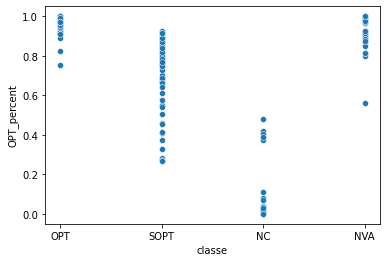

In [16]:
sns.scatterplot(data= df_test_global, x="classe", y="OPT_percent")